# Step 1: Setup

## Define software versions

In [ ]:
%tensorflow_version 1.x

In [ ]:
!pip install segmentation-models==1.0.1

In [ ]:
!pip uninstall -y h5py 
!pip install 'h5py < 3.0.0'

## Import all of the necessary modules

In [ ]:
import keras
import segmentation_models as sm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import json
import cv2
import os
import random
from keras.utils import normalize
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import Adam
import datetime
from skimage.transform import resize

# Step 2: Load our masked images

The following code loads our images and masks from google drive and stores them in arrays. Our masks are in a JSON format which were generated using a package called lableme which can be found at the following link: https://github.com/wkentaro/labelme

In [ ]:
# Arrays which will store our image and mask data
images = []
masks = []

def get_data_dicts(directory):
    '''Function to load all of our masks and image data from a specified directory'''
    # Loop through all of our json mask files in the specified directory
    for idx, filename in enumerate([file for file in os.listdir(directory) if file.endswith('.json')]):

        # Lets get our filenames for our image and mask
        json_file = os.path.join(directory, filename)
        image_filename = os.path.splitext(filename)[0]+'.jpg'

        # Load the image
        img = cv2.imread(os.path.join(directory, image_filename))

        # Open the mask file
        with open(json_file) as json_file:
          # Load the json data
          data = json.load(json_file)

          # Create a polygon of the mask from our json data
          area = np.array(data['shapes'][0]['points']).astype(int)
          filled = np.zeros_like(img)
          filled = cv2.fillPoly(filled, pts = [area], color =(255,255,255))

          # Append our image and mask to our arrays
          masks.append(filled/255)
          images.append(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR))

# Call the function
get_data_dicts("/content/drive/MyDrive/Dissertation/data/project/v3/")

## Lets check the shape of our loaded data

Stack our images and masks into np arrays, and check that they have the same shape

In [ ]:
images = np.stack(images, 0)
masks = np.stack(masks, 0)
print(images.shape)
print(masks.shape)

(260, 480, 640, 3)
(260, 480, 640, 3)


## Lets now sanity check some of our masks and images

(260, 480, 640, 3)
(195, 480, 640, 3)
(195, 480, 640, 3)


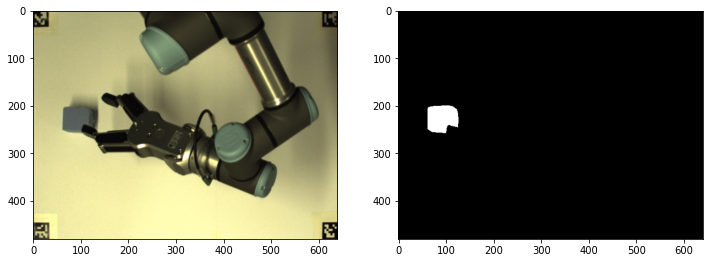

In [ ]:
# Lets first preprocess our image based on our backbone
BACKBONE = "resnet34"
preprocess_input = sm.get_preprocessing(BACKBONE)
preprocessed_images = preprocess_input(images)
# Check that our preprocessed images are of the right shape
print(preprocessed_images.shape)

# Lets now define our training and test split, because from this point onward we do not want to use any test data
X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, masks, test_size = 0.25, random_state = 0)

# Lets select a random image from our training batch
image_number = random.randint(0, len(X_train) - 1)
plt.figure(figsize=(12, 6))
# We want to show the mask alongside the image and so we use a subplot 
plt.subplot(121)
plt.imshow(X_train[image_number], cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number], cmap='gray')

# Lets also print the shape of our training data so that we know how many images we are working with
# and if our training and test partition worked
print(X_train.shape)
print(y_train.shape)

# Lets now show the mask alongside the image
plt.show()

# Step 3: Data Augmentation 

Due to the fact that we only have a certain amount of labelled data, we use data augmentation techniques to create more data. We define generators that augment our data with image shift, sheer, zoom rotations and flips. 

## Lets first define our generator arguments

In [ ]:
# We define our seed as we want to synchronize our image and mask data augmentation
# In other words we want our mask augmentation to be the same as our image
seed=24
from keras.preprocessing.image import ImageDataGenerator

# Define our image generator arguments
img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

# Define our mask generator arguments, note that we use the same parameters 
# for masks and images as we want our mask to be augmented by the same 
# amount as our image
mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) # We want our mask to be binary 

## Lets now define our image and mask generators

In [ ]:
# Lets first define the batch size we want to use in our generator flow
batch_size= 16

# First define an instance of ImageDataGenerator for our images 
# We do this based on the arguments we have just defined
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

# Next we define an instance of ImageDataGenerator for our masks 
# We do this based on the arguments we have just defined
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)  #Default batch size 32, if not specified here

# Lets now define the combined training and validation generator
# We do this by defining the following function which takes both our 
# generators as input and yields the combined result
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

# Lets define the training data generator
my_generator = my_image_mask_generator(image_generator, mask_generator)
# Lets now define the validation data generator
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

## Sanity check our image generators (augmentation techniques)

lets check that our generators are working properly by viewing a few augmented images and masks

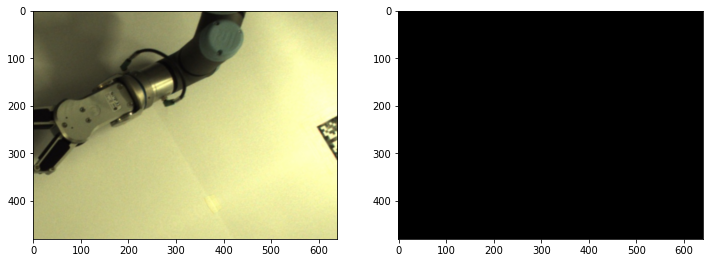

In [ ]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    plt.figure(figsize=(12, 6))
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,:].astype('uint8'), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()

# Step 4: Define and train ML Model

## Load the U-Net architecture

In [ ]:
BACKBONE = "resnet34"
model = sm.Unet(BACKBONE, encoder_weights="imagenet")
model.compile('Adam', loss = sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])
print(model.summary())

In [ ]:
training_num = 18
training_folder_path = "training_" + str(training_num) + "/"
checkpoint_path = training_folder_path + "cp.ckpt"

In [ ]:
os.mkdir("/content/drive/MyDrive/Dissertation/checkpoints/project/" + training_folder_path)
os.mkdir("/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path)
os.mkdir("/content/drive/MyDrive/Dissertation/saved_models/project/"+ training_folder_path)

checkpoint_dir = os.path.join("/content/drive/MyDrive/Dissertation/checkpoints/project/", checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

log_dir = "/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

### Train the model

In [ ]:
history = model.fit(my_generator, validation_data=validation_datagen,steps_per_epoch=50,validation_steps=50,epochs=300, callbacks=[tensorboard_callback, cp_callback])

### Save the model

In [ ]:
model.save("/content/drive/MyDrive/Dissertation/saved_models/sponge/" + training_folder_path + "my_model_" + str(training_num) + ".h5")

In [ ]:
training_num = 602

training_folder_path = "training_" + str(training_num) + "/"

os.mkdir("/content/drive/MyDrive/Dissertation/checkpoints/project/" + training_folder_path)
os.mkdir("/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path)
os.mkdir("/content/drive/MyDrive/Dissertation/saved_models/project/"+ training_folder_path)

model = sm.Unet(BACKBONE, encoder_weights="imagenet")
model.compile('Adam', loss = sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])

test_version = "bs_16_run_1"
checkpoint_path = training_folder_path + test_version + "/" + "cp.ckpt"
os.mkdir("/content/drive/MyDrive/Dissertation/checkpoints/project/" + training_folder_path + test_version + "/")
os.mkdir("/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path + test_version + "/")
checkpoint_dir = os.path.join("/content/drive/MyDrive/Dissertation/checkpoints/project/", checkpoint_path)
log_dir = "/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path + test_version + "/"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,save_weights_only=True, save_best_only=True, verbose=1)

history = model.fit(my_generator, validation_data=validation_datagen,steps_per_epoch=100,validation_steps=100,epochs=50, callbacks=[tensorboard_callback, cp_callback])

model = sm.Unet(BACKBONE, encoder_weights="imagenet")
model.compile('Adam', loss = sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])

test_version = "bs_16_run_2"
checkpoint_path = training_folder_path + test_version + "/" + "cp.ckpt"
os.mkdir("/content/drive/MyDrive/Dissertation/checkpoints/project/" + training_folder_path + test_version + "/")
os.mkdir("/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path + test_version + "/")
checkpoint_dir = os.path.join("/content/drive/MyDrive/Dissertation/checkpoints/project/", checkpoint_path)
log_dir = "/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path + test_version + "/"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,save_weights_only=True, save_best_only=True, verbose=1)

history = model.fit(my_generator, validation_data=validation_datagen,steps_per_epoch=100,validation_steps=100,epochs=50, callbacks=[tensorboard_callback, cp_callback])

model = sm.Unet(BACKBONE, encoder_weights="imagenet")
model.compile('Adam', loss = sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])

test_version = "bs_16_run_3"
checkpoint_path = training_folder_path + test_version + "/" + "cp.ckpt"
os.mkdir("/content/drive/MyDrive/Dissertation/checkpoints/project/" + training_folder_path + test_version + "/")
os.mkdir("/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path + test_version + "/")
checkpoint_dir = os.path.join("/content/drive/MyDrive/Dissertation/checkpoints/project/", checkpoint_path)
log_dir = "/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path + test_version + "/"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,save_weights_only=True, save_best_only=True, verbose=1)

history = model.fit(my_generator, validation_data=validation_datagen,steps_per_epoch=100,validation_steps=100,epochs=50, callbacks=[tensorboard_callback, cp_callback])

model = sm.Unet(BACKBONE, encoder_weights="imagenet")
model.compile('Adam', loss = sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])

test_version = "bs_16_run_4"
checkpoint_path = training_folder_path + test_version + "/" + "cp.ckpt"
os.mkdir("/content/drive/MyDrive/Dissertation/checkpoints/project/" + training_folder_path + test_version + "/")
os.mkdir("/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path + test_version + "/")
checkpoint_dir = os.path.join("/content/drive/MyDrive/Dissertation/checkpoints/project/", checkpoint_path)
log_dir = "/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path + test_version + "/"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,save_weights_only=True, save_best_only=True, verbose=1)

history = model.fit(my_generator, validation_data=validation_datagen,steps_per_epoch=100,validation_steps=100,epochs=50, callbacks=[tensorboard_callback, cp_callback])

model = sm.Unet(BACKBONE, encoder_weights="imagenet")
model.compile('Adam', loss = sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])

test_version = "bs_16_run_5"
checkpoint_path = training_folder_path + test_version + "/" + "cp.ckpt"
os.mkdir("/content/drive/MyDrive/Dissertation/checkpoints/project/" + training_folder_path + test_version + "/")
os.mkdir("/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path + test_version + "/")
checkpoint_dir = os.path.join("/content/drive/MyDrive/Dissertation/checkpoints/project/", checkpoint_path)
log_dir = "/content/drive/MyDrive/Dissertation/logs/project/" + training_folder_path + test_version + "/"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,save_weights_only=True, save_best_only=True, verbose=1)

history = model.fit(my_generator, validation_data=validation_datagen,steps_per_epoch=100,validation_steps=100,epochs=50, callbacks=[tensorboard_callback, cp_callback])


In [ ]:
# Loads the weights
model.load_weights("/content/drive/MyDrive/Dissertation/checkpoints/project/" + checkpoint_path)
#model.save("/content/drive/MyDrive/Dissertation/saved_models/project/" + training_folder_path + "my_model_" + str(training_num) + ".h5")

In [ ]:
evaluation = model.evaluate(X_test, y_test)
print("Model evaluation:", evaluation)

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# Results:

Lets calculate the IoU 

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)


IoU socre is:  0.8719294904926417


# Predictions:

The following section will run and display a few predictions of the model in both a binary mask and with coloured masks for better clarity.

0.04002118110656738


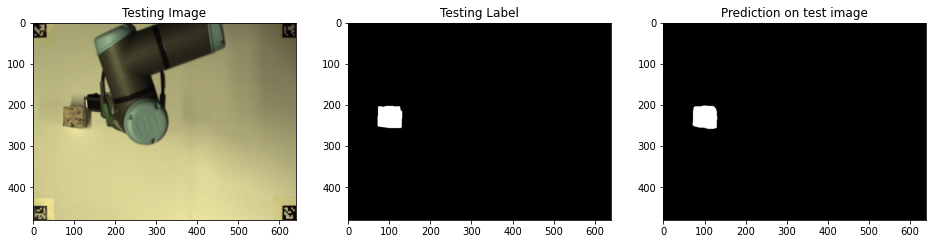

In [ ]:
#Predict on a few images
import time

test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
start = time.time()
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.9).astype(np.uint8)
end = time.time()
print(end - start)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

0.04887056350708008


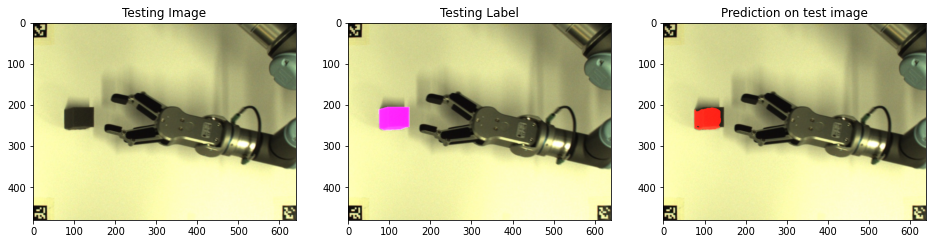

In [ ]:
test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]

test_img_input=np.expand_dims(test_img, 0)
start = time.time()

prediction = (model.predict(test_img_input)[0,:,:,0] > 0.9).astype(np.uint8)*255

redImg = np.zeros(test_img.shape, test_img.dtype)
redImg[:,:] = (255, 0, 0)
redMask = cv2.bitwise_and(redImg, redImg, mask=prediction)
added_image = cv2.addWeighted(test_img,1.0,redMask,0.9,0)

new_pred_2 = ground_truth[:,:,0].astype(np.uint8)

gtredimage = np.zeros(test_img.shape, test_img.dtype)
gtredimage[:,:] = (255, 0, 255)
gtredMask = cv2.bitwise_and(gtredimage, gtredimage, mask=new_pred_2)
gtadded_image = cv2.addWeighted(test_img,1.0,gtredMask,0.9,0)

end = time.time()
print(end - start)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(gtadded_image, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(added_image, cmap='gray')

plt.show()